# Агент для генерации LeanCanvas

## Введение

Этот ноутбук демонстрирует создание интеллектуального агента для автоматической генерации **Lean Canvas** — популярного инструмента для описания бизнес-модели стартапов. Lean Canvas помогает структурированно описать ключевые аспекты бизнеса: проблему, решение, целевую аудиторию, каналы привлечения клиентов и другие важные элементы.

### Решаемая задача
Агент автоматизирует процесс создания Lean Canvas на основе краткого описания бизнес-идеи. Вместо ручного заполнения 9 блоков таблицы, пользователь просто описывает свою идею, а агент:
- Анализирует конкурентов через поиск в интернете
- Генерирует уникальные предложения
- Заполняет все разделы Lean Canvas
- Позволяет пользователю корректировать результат

### Демонстрируемые принципы LangGraph

В этом ноутбуке показаны ключевые концепции работы с **LangGraph**:

1. **ReAct агенты** — агенты, которые могут рассуждать (Reasoning) и действовать (Acting), используя внешние инструменты (поиск в интернете)

2. **Structured Output** — получение структурированных ответов от LLM в виде Pydantic моделей вместо произвольного текста

3. **State Graphs** — создание сложных workflow с состоянием, где каждый узел выполняет определенную задачу и обновляет глобальное состояние

4. **Human in the Loop** — интеграция человека в процесс работы агента для предоставления обратной связи и корректировок

5. **Interrupt & Resume** — механизм прерывания выполнения графа для получения пользовательского ввода и последующего возобновления работы

6. **Conditional Routing** — динамическое определение следующего шага на основе результатов анализа (например, переход к генерации нового предложения, если текущее не уникально)

7. **Memory & Checkpoints** — сохранение состояния между вызовами для возможности продолжения работы

Этот пример показывает, как можно создавать сложные многошаговые агенты, которые сочетают автоматизацию с возможностью человеческого контроля и корректировки.


# Настраиваем окружение

Установка зависимостей

In [37]:
!pip install langchain_gigachat langchain_community langgraph duckduckgo-search langchain_tavily -q


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Настройка переменных окружения

Для корректной работы примера в переменных окружения должны быть указаны параметры для подключения к GigaChat API. Подробно о том, как создать проект GigaChat API — в официальной документации, в разделах [Быстрый старт для физических лиц](https://developers.sber.ru/docs/ru/gigachat/individuals-quickstar) и [Быстрый старт для ИП и юридических лиц](https://developers.sber.ru/docs/ru/gigachat/legal-quickstart).

### Шаги настройки:

1. **Переименуйте файл `.env.example` в `.env`**
2. **Заполните файл `.env` необходимыми данными:**
    - Данные для подключения к GigaChat API
    - API ключ для Tavily (для поиска в интернете)

Подробная инструкция по настройке переменных окружения доступна в [официальном репозитории GigaChat](https://github.com/ai-forever/gigachat?tab=readme-ov-file#%D0%BD%D0%B0%D1%81%D1%82%D1%80%D0%BE%D0%B9%D0%BA%D0%B0-%D0%BF%D0%B5%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85-%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F).

In [1]:
from rich import print
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

## Подключаем GigaChat и проверяем его работу

In [2]:
from langchain_gigachat import GigaChat

llm = GigaChat(model="GigaChat-2-Max", profanity_check=False, top_p=0, timeout=120)
print(llm.invoke("Кто тебя сделал?").content)

Меня создала компания Sber в России в 2023 году.

## Создаем ReAct агента с возможностью поиска в интернете

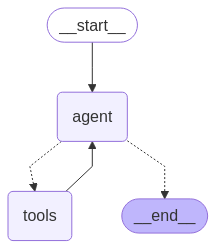

In [3]:
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import DuckDuckGoSearchRun # !pip install duckduckgo_search

search_tool = DuckDuckGoSearchRun()

agent = create_react_agent(llm, tools=[search_tool], prompt="Ты полезный ассистент")
agent

In [4]:
inputs = {"messages": [("user", "Какая самая дорогая компания в мире на сегодня?")]}
messages = agent.invoke(inputs)['messages']

In [5]:
print(messages[-1].content)

На сегодняшний день самой дорогой компанией в мире является **Apple**, ее рыночная капитализация составляет около 
$3.548$ трлн долларов. За ней следуют:

- **Microsoft** — $3.085$ трлн.
- **NVIDIA** — $2.940$ трлн.

Однако стоит учитывать, что позиции могут меняться ежедневно из-за колебаний стоимости акций.

## Изучим лог работы агента
Видно, что агент сначала сделал вызов функции, затем LLM обработала результат поиска и потом подготовила итоговый ответ для пользователя.

In [6]:
print(messages)

[
    HumanMessage(
        content='Какая самая дорогая компания в мире на сегодня?',
        additional_kwargs={},
        response_metadata={},
        id='dda53a52-8fac-4569-92f2-f54203b998e0'
    ),
    AIMessage(
        content='',
        additional_kwargs={
            'function_call': {
                'name': 'duckduckgo_search',
                'arguments': {'query': 'самая дорогая компания в мире на сегодня'}
            },
            'functions_state_id': 'c96bf35f-6807-4892-b457-b9ba6234b906'
        },
        response_metadata={
            'token_usage': {
                'prompt_tokens': 105,
                'completion_tokens': 35,
                'total_tokens': 140,
                'precached_prompt_tokens': 2
            },
            'model_name': 'GigaChat-2-Max:2.0.28.02',
            'x_headers': {
                'x-request-id': '9c508037-d637-4209-a6e0-6bf6bd1b6d5a',
                'x-session-id': 'affb8502-0739-4251-84a3-daad2b1f91d6',
                'x-client-id': None
            },
            'finish_reason': 'function_call'
        },
        id='9c508037-d637-4209-a6e0-6bf6bd1b6d5a',
        tool_calls=[
            {
                'name': 'duckduckgo_search',
                'args': {'query': 'самая дорогая компания в мире на сегодня'},
                'id': '8ff7f9c2-6a06-4cf7-b7c1-61c4515ae4e8',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'output_tokens': 35,
            'input_tokens': 105,
            'total_tokens': 140,
            'input_token_details': {'cache_read': 2}
        }
    ),
    ToolMessage(
        content='Собрали самые дорогие компании по рыночной капитализации. Не забывайте, что этот список постоянно 
обновляется - данные актуальны на декабрь 2024. 1. Apple Inc. (AAPL) Apple остаётся лидером, предлагая 
инновационные устройства и укрепляя свою экосистему продуктов. 2. NVIDIA Corporation (NVDA) Акции Nvidia на прошлой
неделе достигли рекордного максимума, сделав производителя чипов первой компанией в истории, чья стоимость на 
фондовом рынке превысила 3,6 триллиона долларов. Рассказываем о рейтинге самых дорогих компаний в мире, месте 
Nvidia в нем и объясняем, какие действия, технологии и чипы компании в сфере искусственного интеллекта на это 
повлияли В 2025 году самой дорогой компанией в мире является Apple с рыночной капитализацией в 3.548 трлн долларов 
. На втором месте - Microsoft ($3.085 трлн). Третье место занимает NVIDIA с капитализацией 2.940 трлн долларов. 
Далее мы рассмотрим рейтинг десяти крупнейших компаний в мире, отсортированных по рыночной капитализации. NVIDIA. 
На прошлой неделе Nvidia на время стала самой дорогой компанией в мире, обогнав Microsoft. Однако затем цена акций 
компании снизилась, и она опустилась на третью строчку рейтинга самых дорогих корпораций. Однако Nvidia по-прежнему
остается самой быстрорастущей компанией в мире.',
        name='duckduckgo_search',
        id='ec76a6d8-c52a-460b-b5bd-15223a17f1ad',
        tool_call_id='8ff7f9c2-6a06-4cf7-b7c1-61c4515ae4e8'
    ),
    AIMessage(
        content='На сегодняшний день самой дорогой компанией в мире является **Apple**, ее рыночная капитализация 
составляет около $3.548$ трлн долларов. За ней следуют:\n\n- **Microsoft** — $3.085$ трлн.\n- **NVIDIA** — $2.940$ 
трлн.\n\nОднако стоит учитывать, что позиции могут меняться ежедневно из-за колебаний стоимости акций.',
        additional_kwargs={'functions_state_id': '2bbf11fd-aa2a-4405-8688-46b1ba97fa8f'},
        response_metadata={
            'token_usage': {
                'prompt_tokens': 440,
                'completion_tokens': 85,
                'total_tokens': 525,
                'precached_prompt_tokens': 2
            },
            'model_name': 'GigaChat-2-Max:2.0.28.02',
            'x_headers': {
                'x-request-id': 'd43b83cf-4bb2-47c3-8279-bf7855d55d8b',
                'x-session-id': '3b6a78b8-1bde-4060-8459-6319e979da21',
                'x-c

# LeanCanvas
Мы создадим пример заполнения таблицы Lean Canvas. Подробнее про этот подход можно прочитать на [Хабре](https://habr.com/ru/companies/productstar/articles/508994/)

## Structured output - наивный подход

In [7]:
from pydantic import BaseModel

class LeanCanvasResult(BaseModel):
    """
    Представляет результат генерации Lean Canvas.
    Каждое поле соответствует разделу Lean Canvas.
    """
    problem: str  # Проблема, которую пытается решить продукт или услуга.
    solution: str  # Краткое описание предлагаемого решения.
    key_metrics: str  # Ключевые показатели, которые необходимо измерять для отслеживания прогресса.
    unique_value_proposition: str  # Единое, ясное и убедительное сообщение, объясняющее, почему вы отличаетесь от других и почему стоит покупать именно у вас.
    unfair_advantage: str  # То, что конкуренты не могут легко скопировать или купить.
    channels: str  # Пути охвата ваших клиентских сегментов.
    customer_segments: str  # Целевая аудитория или группы людей, которых вы пытаетесь охватить.
    cost_structure: str  # Основные затраты, связанные с ведением бизнеса.
    revenue_streams: str  # Как бизнес будет зарабатывать деньги.

Выше мы создали **Pydantic модель** - это демонстрация технологии **Structured Output**.

**Что это дает:**
- Вместо произвольного текста LLM возвращает данные в строго определенном формате
- Автоматическая валидация ответов
- Возможность программно работать с результатами

In [9]:
structured_llm = llm.with_structured_output(LeanCanvasResult)

prompt = "Создайте Lean Canvas для онлайн-платформы изучения языков, которая связывает изучающих язык с носителями языка."

print(structured_llm.invoke(prompt))

LeanCanvasResult(
    problem='Трудности в изучении языка самостоятельно, нехватка практики общения с носителями языка, отсутствие 
мотивации и дисциплины, высокие цены на традиционные курсы.  ",\n    ',
    solution='Онлайн-платформа, связывающая изучающих язык с носителями языка для практики общения, доступ к 
учебным материалам и сообществу единомышленников.  ",\n    ',
    key_metrics='Количество активных пользователей, количество проведенных уроков, средняя продолжительность урока,
коэффициент удержания пользователей, доход на одного пользователя.  ",\n    ',
    unique_value_proposition='Изучение языка с носителями в удобном формате и по доступной цене, возможность 
практиковаться в реальном общении и получать обратную связь от опытных пользователей.  "\n}',
    unfair_advantage='Уникальная система подбора партнеров по языку, персонализированные рекомендации, доступ к 
носителям языка из разных стран, возможность учиться в удобное время.  ",\n    ',
    channels='Платформы социальных сетей, реферальные программы, SEO, контент-маркетинг, партнерства с языковыми 
школами и университетами.  ",\n    ',
    customer_segments='Изучающие иностранные языки, студенты, путешественники, эмигранты, профессионалы, желающие 
улучшить свои языковые навыки.  ",\n    ',
    cost_structure='Разработка и поддержка платформы, маркетинг и привлечение пользователей, оплата труда 
модераторов и администраторов, юридические и бухгалтерские расходы.  ",\n    ',
    revenue_streams='Подписка на платформу, комиссия с каждого урока, продажа дополнительных материалов и услуг, 
премиум-функции.  ",\n    '
)

Выше мы увидели как работает принудительное структурирование ответа:
- LLM получил свободный запрос про языковую платформу
- Но **обязательно** ответил в формате нашей Pydantic модели
- Все 9 полей Lean Canvas заполнились автоматически

Теперь  реализуем этот подход в рамках агента.

## Агентный подход

### Стейт графа
Глобальное пространство данных в котором идет работа с графом

Используем такой же структурированный подход, но будем получать не сразу заполненный Lean Canvas, а поэтапно, перемещаясь по графу. При этом у нас заранее будет задана структура данных, которая заполнится, когда будут пройдены шаги от начала графа и до конца. 

In [10]:
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict, Annotated

class LeanGraphState(TypedDict):
    main_task: Annotated[str, "Основная задача от пользователя"]
    competitors_analysis: Annotated[str, "Анализ конкурентов"]
    feedback: Annotated[str, "Фидбек от пользователя. Обязательно учитывай его в своих ответах!"]

    # Lean Canvas
    problem: Annotated[str, "Проблема, которую пытается решить продукт или услуга."]
    solution: Annotated[str, "Краткое описание предлагаемого решения."]
    key_metrics: Annotated[str, "Ключевые показатели, которые необходимо измерять для отслеживания прогресса."]
    unique_value_proposition: Annotated[str, "Единое, ясное и убедительное сообщение, объясняющее, почему вы отличаетесь от других и почему стоит покупать именно у вас."]
    unfair_advantage: Annotated[str, "То, что конкуренты не могут легко скопировать или купить."]
    channels: Annotated[str, "Пути охвата ваших клиентских сегментов."]
    customer_segments: Annotated[str, "Целевая аудитория или группы людей, которых вы пытаетесь охватить."]
    cost_structure: Annotated[str, "Основные затраты, связанные с ведением бизнеса."]
    revenue_streams: Annotated[str, "Как бизнес будет зарабатывать деньги."]


def state_to_string(state: LeanGraphState) -> str:
    """
    Преобразует состояние в строку для отображения.
    """
    result = []
    for field, annotation in LeanGraphState.__annotations__.items():
        value = state.get(field, "")
        if value:
            # annotation is typing.Annotated[type, description]
            if hasattr(annotation, "__metadata__") and annotation.__metadata__:
                desc = annotation.__metadata__[0]
            else:
                desc = ""
            result.append(f"{desc} ({field}): {value}")
    return "\n".join(result)


### Основные шаги генерации
Ниже представлены функция-обертка для обращения к LLM и функции узлов заполнения Lean Canvas.

In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langgraph.types import interrupt
from langchain_core.runnables.config import RunnableConfig

def ask_llm(state: LeanGraphState, question: str, config: RunnableConfig) -> str:
    TEMPLATE = """
    Ты - эксперт в области стартапов и Lean Canvas. Твоя задача - помочь пользователю создать Lean Canvas для его задачи.
    Учитывай уже заполненные части таблицы Lean Canvas и главную задачу пользователя (main_task).
    
    Обязательно учитывай фидбек от пользователя (feedback), если он задан.
    <STATE>
    {state}
    </STATE>
    
    Ответь на вопрос: {question}
    Отвечай коротко, не более 1-2 коротких предложений и обязательно учти фидбек от пользователя (feedback), если он задан. Оформи ответ в виде буллетов.
    """
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", TEMPLATE)
    ])
    
    model  = config["configurable"].get("model", "GigaChat-2-Max")
    chain = prompt | llm.bind(model=model) | StrOutputParser()
    return chain.invoke({"state": state_to_string(state), "question": question})

def customer_segments(state: LeanGraphState, config: RunnableConfig):
    return {"customer_segments": ask_llm(state, "Кто ваши целевые клиенты?", config)}

def problem(state: LeanGraphState, config: RunnableConfig):
    return {"problem": ask_llm(state, "Какую проблему вы решаете?", config)}

def unique_value_proposition(state: LeanGraphState, config: RunnableConfig):
    return {"unique_value_proposition": ask_llm(state, "Какое уникальное предложение вы предлагаете?", config)}

def solution(state: LeanGraphState, config: RunnableConfig):
    return {"solution": ask_llm(state, "Какое решение вы предлагаете для этой проблемы?", config)}

def channels(state: LeanGraphState, config: RunnableConfig):
    return {"channels": ask_llm(state, "Какие каналы привлечения клиентов вы используете?", config)}

def revenue_streams(state: LeanGraphState, config: RunnableConfig):
    return {"revenue_streams": ask_llm(state, "Как вы планируете зарабатывать деньги?", config)}

def cost_structure(state: LeanGraphState, config: RunnableConfig):
    return {"cost_structure": ask_llm(state, "Какова структура ваших затрат?", config)}

def key_metrics(state: LeanGraphState, config: RunnableConfig):
    return {"key_metrics": ask_llm(state, "Какие ключевые показатели вы будете отслеживать?", config)}

def unfair_advantage(state: LeanGraphState, config: RunnableConfig):
    return {"unfair_advantage": ask_llm(state, "Какое ваше конкурентное преимущество?", config)}

### Агент проверки уникальности идеи
- Использует интернет для формирования действительно уникальных предложений
- Принимает решение - нужно ли генерировать новые идеи или можно продолжать генерацию
- Демонстрирует принцип handoff с помощью Command

In [12]:
from typing_extensions import Literal
from langgraph.types import Command
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_tavily import TavilySearch

class CompetitorsAnalysisResult(BaseModel):
    """Анализ конкурентов"""
    thoughts: str = Field(description="Мысли по поводу ответа")
    solution: str = Field(description="Какие конкуренты существуют и чем они отличаются от вашего продукта")
    is_unique: bool = Field(description="Уникально ли ваше предложение?")

COMPETITION_ANALYSIS_TEMPLATE = """Ты работаешь над таблицей Lean Canvas и тебе нужно проанализировать конкурентов.

Учитывай уже заполненные части таблицы Lean Canvas и главную задачу пользователя (main_task).
<STATE>
{state}
</STATE>

Результаты поиска по запросу "{unique_value_proposition}". Учитывай их, чтобы понять, уникальную ли идею ты придумал.
Если в поиске нет ничего похожего, значит идея вероятно уникальная.
<SEARCH_RESULTS>
{search_results}
</SEARCH_RESULTS>

Выведи только следующую информацию в формате JSON:
{format_instructions}"""

def check_unique(state: LeanGraphState, config: RunnableConfig) -> Command[Literal["4_solution", "3_unique_value_proposition"]]:
    if config["configurable"].get("skip_search", False):
        # Если пропускаем поиск, то просто переходим к следующему шагу
        return Command(goto="4_solution")
    
    parser = PydanticOutputParser(pydantic_object=CompetitorsAnalysisResult)
    prompt = ChatPromptTemplate.from_messages([
        ("system", COMPETITION_ANALYSIS_TEMPLATE)
    ]).partial(format_instructions=parser.get_format_instructions())
    
    search_results_text = TavilySearch().run(state["unique_value_proposition"])    
    
    chain = prompt | llm | parser
    res = chain.invoke(
        {
            "state": state_to_string(state),
            "unique_value_proposition": state["unique_value_proposition"],
            "search_results": search_results_text
        }
    )
    
    competitors_analysis = state.get("competitors_analysis", "") + "\n" + state["unique_value_proposition"] + " - " + res.solution
    
    if res.is_unique:
        # Если предложение уникально, переходим к следующему шагу
        return Command(
            update={"competitors_analysis": competitors_analysis.strip()},
            goto="4_solution",
        )
    else:
        # Если предложение не уникально, возвращаемся к шагу "3_unique_value_proposition"
        return Command(
            update={"competitors_analysis": competitors_analysis.strip()},
            goto="3_unique_value_proposition",
        )


### Фидбек от пользователя
- Human in the loop
- Interrupt
- Handoff

In [13]:
from typing import Literal, TypeAlias

RedirectStep: TypeAlias = Literal[
    "1_customer_segments",
    "2_problem",
    "3_unique_value_proposition",
    "4_solution",
    "5_channels",
    "6_revenue_streams",
    "7_cost_structure",
    "8_key_metrics",
    "9_unfair_advantage",
    "__end__"
]

class UserFeedback(BaseModel):
    """Анализ конкурентов"""
    feedback: str = Field(description="Фидебек пользователя, что надо исправить")
    next_step: RedirectStep = Field(description="Следующий шаг в Lean Canvas")
    is_done: bool = Field(description="Можно ли завершать создание Lean Canvas?")
    
FEEDBACK_TEMPLATE = """Ты работаешь над таблицей Lean Canvas. Ты уже сгенерировал версию Lean Canvas и получил фидбек от пользователя.
Тебе нужно разобраться фидбек и понять, как действовать дальше, заполнив таблицу с ответом.

Учитывай уже заполненные части таблицы Lean Canvas и главную задачу пользователя (main_task).
<STATE>
{state}
</STATE>

Вот фидбек пользователя на твою работу:
{feedback}

Извлеки из него данные для дальнейшей работы. Если пользователь всем доволен или не говорит ничего конкретного, 
то прими решение закончить генерацию (is_done = True).
Выведи только следующую информацию в формате JSON:
{format_instructions}"""

def get_feedback(state: LeanGraphState, config: RunnableConfig) -> Command[RedirectStep]:
    if config["configurable"].get("need_interrupt"):
        feedback = interrupt("""Пожалуйста, дайте обратную связь по Lean Canvas. Если все хорошо, напишите 'Хорошо'. 
    Если нужно что-то изменить, напишите, что именно и с какого шага начать.""")
    else:
        feedback = "Все хорошо!"

    parser = PydanticOutputParser(pydantic_object=UserFeedback)
    prompt = ChatPromptTemplate.from_messages([
        ("system", FEEDBACK_TEMPLATE)
    ]).partial(format_instructions=parser.get_format_instructions())
    
  
    chain = prompt | llm | parser
    res = chain.invoke(
        {
            "state": state_to_string(state),
            "feedback": feedback,
        }
    )
    
    if res.is_done:
        return Command(update={}, goto=END)
    else:
        # Если предложение не уникально, возвращаемся к шагу "3_unique_value_proposition"
        return Command(
            update={"feedback": res.feedback},
            goto=res.next_step,
        )


# Сборка графа
Соберем узлы графа в правильную последовательность действий, добавим чек-пойнты для сохранения состояний и преобразуем в исполняемое приложение.

In [14]:
from langgraph.checkpoint.memory import MemorySaver

graph = StateGraph(LeanGraphState)

graph.add_node("1_customer_segments", customer_segments)
graph.add_node("2_problem", problem)
graph.add_node("3_unique_value_proposition", unique_value_proposition)
graph.add_node("3.1_check_unique", check_unique)
graph.add_node("4_solution", solution)
graph.add_node("5_channels", channels)
graph.add_node("6_revenue_streams", revenue_streams)
graph.add_node("7_cost_structure", cost_structure)
graph.add_node("8_key_metrics", key_metrics)
graph.add_node("9_unfair_advantage", unfair_advantage)
graph.add_node("get_feedback", get_feedback)

graph.add_edge(START, "1_customer_segments")
graph.add_edge("1_customer_segments", "2_problem")
graph.add_edge("2_problem", "3_unique_value_proposition")
graph.add_edge("3_unique_value_proposition", "3.1_check_unique")
graph.add_edge("4_solution", "5_channels")
graph.add_edge("5_channels", "6_revenue_streams")
graph.add_edge("6_revenue_streams", "7_cost_structure")
graph.add_edge("7_cost_structure", "8_key_metrics")
graph.add_edge("8_key_metrics", "9_unfair_advantage")
graph.add_edge("9_unfair_advantage", "get_feedback")

memory = MemorySaver()
app = graph.compile(checkpointer=memory)

Визуализируем получившийся граф.

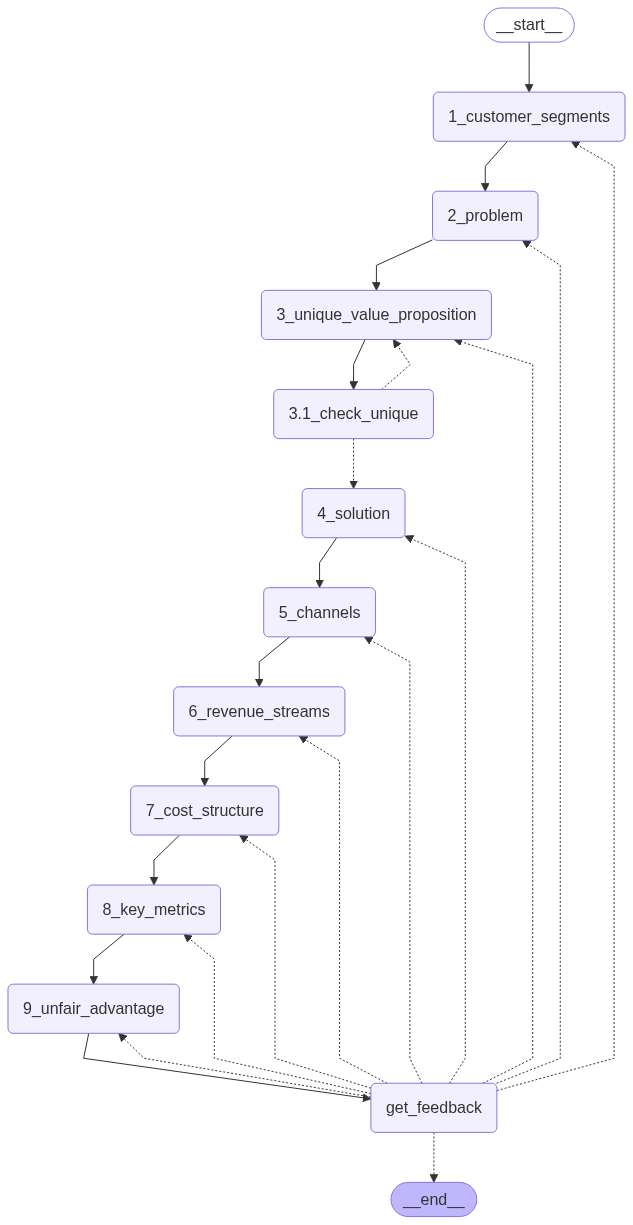

In [15]:
from utils import show_graph
show_graph(app)

Запустим выполнение приложения с помощью функции `execute_graph`.

In [16]:
def execute_graph(inputs, conf: RunnableConfig):
    """Выводит поток событий от агента. Обрабатывает прерывания (human in the loop)"""
    for event in app.stream(inputs, config=conf):
        print(event)
    
    while '__interrupt__' in event:
        print(f"Agent interrupted. {event['__interrupt__'][0].value}")
        user_input = input("User: ")
        print(f"User input: {user_input}")
        for event in app.stream(Command(resume=user_input), config=conf):
            print(event)

In [17]:
import uuid

inputs = {"main_task": "Онлайн платформа для изучения английского языка с AI-агентами"}
conf = {"configurable": {"thread_id": str(uuid.uuid4()),
                         "need_interrupt": True,
                         "skip_search": False,}}

execute_graph(inputs, conf)
        

{
    '1_customer_segments': {
        'customer_segments': '- Студенты и взрослые, изучающие английский язык самостоятельно  \n- Преподаватели 
иностранных языков, использующие современные технологии в обучении'
    }
}

{
    '2_problem': {
        'problem': '- Отсутствие эффективных интерактивных инструментов для самостоятельного изучения английского 
языка.  \n- Ограниченность традиционных методов обучения и нехватка персонализированного подхода.'
    }
}

{
    '3_unique_value_proposition': {
        'unique_value_proposition': '- Уникальная онлайн-платформа с AI-агентами для эффективного и увлекательного 
изучения английского языка.  \n- Персонализированные занятия и интерактивное взаимодействие для быстрого прогресса 
каждого ученика.'
    }
}

{
    '3.1_check_unique': {
        'competitors_analysis': '- Уникальная онлайн-платформа с AI-агентами для эффективного и увлекательного 
изучения английского языка.  \n- Персонализированные занятия и интерактивное взаимодействие для быстрого прогресса 
каждого ученика. - Конкуренты включают такие платформы, как Cambly, Vocalo.ai и другие приложения, основанные на 
искусственном интеллекте. Эти решения предлагают различные подходы к изучению языка, включая практику разговорной 
речи и использование видеоматериалов. Ваше предложение отличается наличием AI-агентов, обеспечивающих 
индивидуализированный подход и интерактивность, что делает его уникальным среди существующих предложений.'
    }
}

{
    '4_solution': {
        'solution': '- Онлайн-платформа с AI-агентами для индивидуального и интерактивного изучения английского 
языка.  \n- Персонализированные занятия обеспечивают быстрый прогресс и увлекательное обучение каждому 
пользователю.'
    }
}

{
    '5_channels': {
        'channels': '- Контекстная реклама и таргетинг в социальных сетях (VK, Instagram).  \n- Партнерство с 
образовательными платформами и языковой школой.'
    }
}

{
    '6_revenue_streams': {
        'revenue_streams': '- Подписка на премиум-функциональность платформы.  \n- Продажа дополнительного 
образовательного контента и индивидуальных курсов.'
    }
}

{
    '7_cost_structure': {
        'cost_structure': '- Разработка и поддержка платформы с AI-агентами  \n- Маркетинговые расходы на 
привлечение пользователей через социальные сети и партнерства  \n- Создание и обновление образовательного контента'
    }
}

{
    '8_key_metrics': {
        'key_metrics': '- Количество активных пользователей ежемесячно (MAU)\n- Уровень удержания пользователей 
(Retention Rate)\n- Средняя продолжительность занятий на платформе\n- Коэффициент конверсии бесплатных 
пользователей в платных подписчиков\n- Оценки удовлетворенности клиентов (NPS — Net Promoter Score)\n- Доход от 
подписки и продажи дополнительного контента'
    }
}

{
    '9_unfair_advantage': {
        'unfair_advantage': '- Наличие уникальных AI-агентов, обеспечивающих индивидуальный и интерактивный подход 
к обучению английскому языку.  \n- Отличие от конкурентов заключается в высокой степени персонализации занятий и 
вовлечении студентов благодаря инновационным технологиям.'
    }
}

{
    '__interrupt__': (
        Interrupt(
            value="Пожалуйста, дайте обратную связь по Lean Canvas. Если все хорошо, напишите 'Хорошо'. \n    Если 
нужно что-то изменить, напишите, что именно и с какого шага начать.",
            resumable=True,
            ns=['get_feedback:5b313d21-f5c4-92b6-e1c3-9b16a111e6f1']
        ),
    )
}

Agent interrupted. Пожалуйста, дайте обратную связь по Lean Canvas. Если все хорошо, напишите 'Хорошо'. 
    Если нужно что-то изменить, напишите, что именно и с какого шага начать.

User:  хорошо


User input: хорошо

{'get_feedback': None}

# Вывод результата

In [18]:
from utils import show_lean_canvas

current_state_values = app.get_state(config=conf).values
state = LeanGraphState(**current_state_values)
# show_lean_canvas(state)

In [19]:
show_lean_canvas(state)

![Lean Canvas](lean_canvas.png)

# Валидация

Теперь покажем, как можно проводить логирование и затем качественно и количественно оценивать результаты работы агента. В качестве платформы для логирования используем [Arize Phoenix](https://phoenix.arize.com/). Этот опенсорс инструмент легко использовать как локально, так и развернув на сервере. 

## Запуск Arize Phoenix

In [ ]:
# !pip install arize-phoenix opentelemetry-exporter-otlp openinference-instrumentation-langchain pandas -U -q

In [16]:
# import phoenix as px
# session = px.launch_app(use_temp_dir=False)

/Users/knkrestnikov/Documents/giga/gigachain/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
💽 Your data is being persisted to sqlite:////Users/knkrestnikov/.phoenix/phoenix.db
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


### Загружаем датасет в Phoenix
В качестве валидационного датасета используем файл validation_data.txt. Преобразуем его в DataFrame и передадим в Phoenix.

In [18]:
with open('validation_data.txt', 'r') as f:
    questions = [line.strip() for line in f]

print(f"Total questions: {len(questions)}")

Total questions: 30

In [ ]:
import pandas as pd
import phoenix as px

dataset_df = pd.DataFrame(data={"question": questions})

px.launch_app()
client = px.Client()

dataset = client.upload_dataset(
    dataframe=dataset_df,
    dataset_name="lean_canvas_questions",
    input_keys=["question"],
)

Existing running Phoenix instance detected! Shutting it down and starting a new instance...
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/contextlib.py:148: SAWarning: Skipped unsupported reflection of expression-based index ix_cumulative_llm_token_count_total
  next(self.gen)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/contextlib.py:148: SAWarning: Skipped unsupported reflection of expression-based index ix_latency
  next(self.gen)


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix
📤 Uploading dataset...
💾 Examples uploaded: http://localhost:6006/datasets/RGF0YXNldDox/examples
🗄️ Dataset version ID: RGF0YXNldFZlcnNpb246MQ==


running experiment evaluations |██        | 6/30 (20.0%) | ⏳ 00:32<02:09 |  5.41s/it


![Dataset](dataset.png)

## Проводим эксперимент на GigaChat Lite

В качестве критерия оценки работы агента можно создать собственную функцию, которая по жесткому алгоритму будет выдавать оценку ответу. Например, зададим просто оценку по длине. Пусть просто оценивается, что длина ответа входит в диапазон от 400 до 3000 символов, а также все 9 полей присутствуют в виде корректного JSON.

In [32]:
from phoenix.experiments import evaluate_experiment, run_experiment
from phoenix.experiments.types import Example
import json

def create_experiment(name, model):
    def run_step(example: Example):
        inputs = {"main_task": example.input["question"]}
        conf = {"configurable": {"thread_id": str(uuid.uuid4()),
                                "model": model,
                                "need_interrupt": False,
                                "skip_search": True,}}
        resp = app.invoke(inputs, config=conf)
        resp.pop("main_task")
        return resp

    def check_structure(expected, output) -> bool:
        resp_st = json.dumps(output, ensure_ascii=False)
        if len(resp_st) > 3000 or len(resp_st) < 400:
            return False
        return True

    return run_experiment(
        client.get_dataset(name="lean_canvas_questions"),
        run_step,
        evaluators=[check_structure],
        experiment_name=name,
        experiment_description="",
    )

experiment = create_experiment("Lean Canvas GigaChat-Lite", "GigaChat-2")    

🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.


🧪 Experiment started.
📺 View dataset experiments: http://localhost:6006/datasets/RGF0YXNldDox/experiments
🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDox


running tasks |██████████| 30/30 (100.0%) | ⏳ 03:43<00:00 |  7.45s/it
🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.


✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |██████████| 30/30 (100.0%) | ⏳ 00:00<00:00 | 119.30it/s


🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDox

Experiment Summary (05/22/25 11:00 PM +0300)
--------------------------------------------
         evaluator   n  n_scores  avg_score  n_labels  \
0  check_structure  30        30   0.033333        30   

               top_2_labels  
0  {'False': 29, 'True': 1}  

Tasks Summary (05/22/25 11:00 PM +0300)
---------------------------------------
   n_examples  n_runs  n_errors
0          30      30         0


## Валидация качества ответа - llm as judge

Часто оценка ответа не может быть оформлена в жесткий алгоритм, поэтому часто используют подход LLM as Judge.

Важно! Данный пример показан только для демонстрации того, как можно делать оценку с помощью LLM и содержит два допуска, которые не нужно повторять в реальной жизни:
- Оценка модели с помощью нее самой. Нужно использовать другую, желательно более мощную модель.
- Оценка по градиентной шкале. Желательно использовать бинарную оценку.

In [35]:
def check_output_quality(output) -> float:
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Оцени качество заполнения полей по шкале от 1 до 5. Верни только число."),
        ("human", "{output}")
    ])
    chain = prompt | llm | StrOutputParser()
    return float(chain.invoke({"output": output}))

evaluate_experiment(experiment, evaluators=[check_output_quality])

🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.


🧠 Evaluation started.


running experiment evaluations |██████████| 30/30 (100.0%) | ⏳ 00:07<00:00 |  3.83it/s


🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDox

Experiment Summary (05/22/25 11:06 PM +0300)
--------------------------------------------
              evaluator   n  n_scores  avg_score
0  check_output_quality  30        30   4.433333

Experiment Summary (05/22/25 11:00 PM +0300)
--------------------------------------------
         evaluator   n  n_scores  avg_score  n_labels  \
0  check_structure  30        30   0.033333        30   

               top_2_labels  
0  {'False': 29, 'True': 1}  

Tasks Summary (05/22/25 11:00 PM +0300)
---------------------------------------
   n_examples  n_runs  n_errors
0          30      30         0


RanExperiment(id='RXhwZXJpbWVudDox', dataset_id='RGF0YXNldDox', dataset_version_id='RGF0YXNldFZlcnNpb246MQ==', repetitions=1)

![Experiment](experement.png)

## Теперь аналогичным образом замерим GigaChat-2-Max

In [36]:
experiment2 = create_experiment("Lean Canvas GigaChat-2-Max", "GigaChat-2-Max")
evaluate_experiment(experiment2, evaluators=[check_output_quality])

🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.


🧪 Experiment started.
📺 View dataset experiments: http://localhost:6006/datasets/RGF0YXNldDox/experiments
🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDoy


running tasks |██████████| 30/30 (100.0%) | ⏳ 04:28<00:00 |  8.95s/it
🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.


✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |██████████| 30/30 (100.0%) | ⏳ 00:00<00:00 | 116.09it/s
🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.



🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDoy

Experiment Summary (05/22/25 11:11 PM +0300)
--------------------------------------------
         evaluator   n  n_scores  avg_score  n_labels  top_2_labels
0  check_structure  30        30        1.0        30  {'True': 30}

Tasks Summary (05/22/25 11:11 PM +0300)
---------------------------------------
   n_examples  n_runs  n_errors
0          30      30         0
🧠 Evaluation started.


running experiment evaluations |██████████| 30/30 (100.0%) | ⏳ 00:07<00:00 |  4.11it/s


🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDoy

Experiment Summary (05/22/25 11:11 PM +0300)
--------------------------------------------
              evaluator   n  n_scores  avg_score
0  check_output_quality  30        30        4.5

Experiment Summary (05/22/25 11:11 PM +0300)
--------------------------------------------
         evaluator   n  n_scores  avg_score  n_labels  top_2_labels
0  check_structure  30        30        1.0        30  {'True': 30}

Tasks Summary (05/22/25 11:11 PM +0300)
---------------------------------------
   n_examples  n_runs  n_errors
0          30      30         0


RanExperiment(id='RXhwZXJpbWVudDoy', dataset_id='RGF0YXNldDox', dataset_version_id='RGF0YXNldFZlcnNpb246MQ==', repetitions=1)

![Experiment 2](experement_2.png)

Стоит отметить, что оценка агентов является сложной задачей, реализация которой может сильно зависить от решаемой агентом задачи, поэтому данный ноутбук показывает лишь техническую сторону (использование платформы Arize Phoenix). Реальная валидация требует качественных данных, глубокого понимания доменной области, для которой создается агент, а также множества итераций по получению инсайтов и постепенному повышению качества ответов агента.